#### Khai báo thư viện cần thiết

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Đọc dữ liệu

In [3]:
# Đọc file dữ liệu
cleaned_df = pd.read_csv('./data/cleaned_air_quality_health_impact_data.csv')

# Đọc file kiểu dữ liệu mỗi cột
data_types = pd.read_csv('./data/data-types.csv')
data_types.set_index(data_types.columns[0], inplace = True)
data_types.index.name = None
# Chuyển đổi kiểu dữ liệu
for name in data_types.index:
    cleaned_df[name] = cleaned_df[name].astype(data_types.loc[name, 'Data Type'])

# Đọc ma trận tương quan
correlation_matrix = pd.read_csv('./data/correlation_matrix.csv')
correlation_matrix.set_index(correlation_matrix.columns[0], inplace = True)
correlation_matrix.index.name = None

#### Phân tích tổng quan

Trước khi đặt và phân tích những câu hỏi về sự ảnh hưởng lẫn nhau của các thuộc tính, ta thực hiện phân tích tổng quan về dữ liệu.
1. Chất lượng không khí
    * Phân phối chỉ số AQI, PM10, PM2.5, NO2, SO2, O3 như thế nào trong bộ dữ liệu?
2. Tác động đến sức khỏe
   * Phân phối của RespiratoryCases, CardiovascularCases, và HospitalAdmissions ra sao? Những trường hợp nào phổ biến nhất?
   * Phân phối các lớp tác động sức khỏe (HealthImpactClass) như thế nào? Lớp nào chiếm ưu thế?
3. Thời tiết và ô nhiễm
   * Điều kiện thời tiết (nhiệt độ, độ ẩm, tốc độ gió) phân phối như thế nào?

##### Sử dụng histogram để xem các chỉ số ô nhiễm tập trung ở những giá trị nào

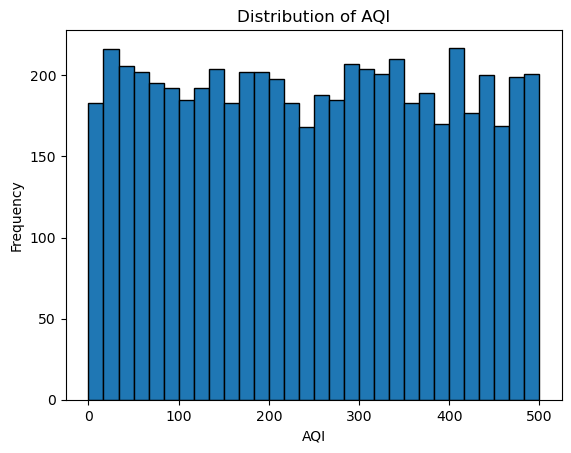

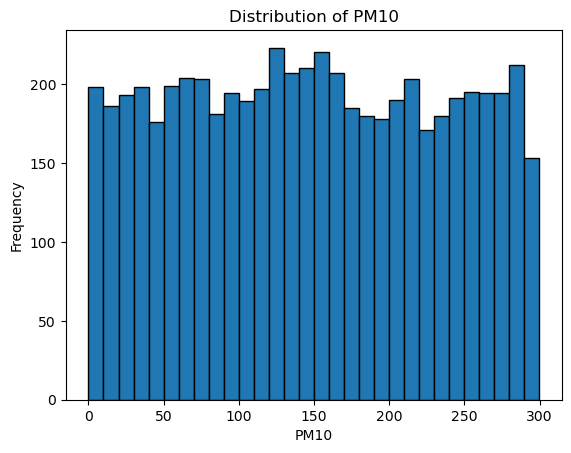

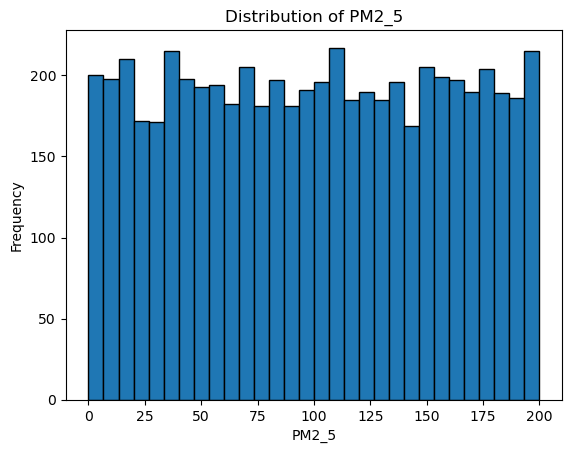

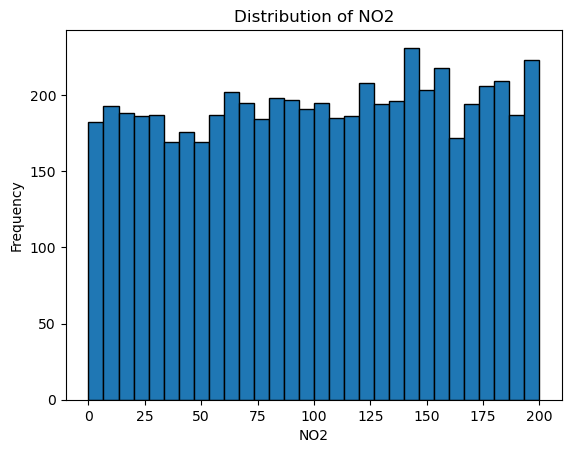

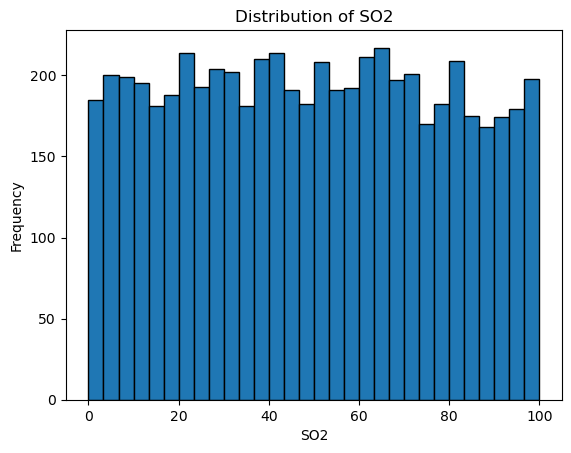

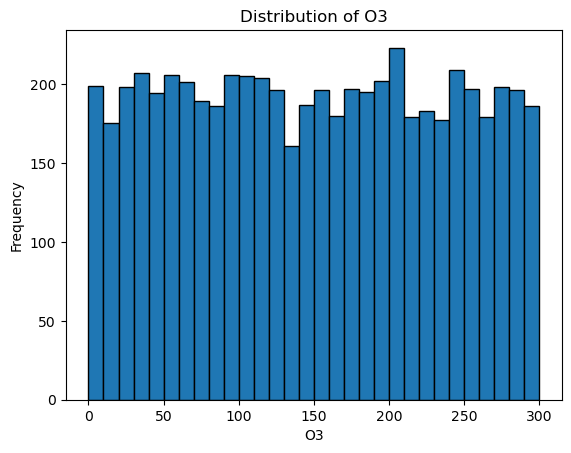

In [3]:
air_quality_metrics = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']

for metric in air_quality_metrics:
    plt.hist(cleaned_df[metric], bins = 30, edgecolor = 'black')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Các dữ liệu phân phố rất đều nhau, không có nhóm nào chiếm ưu thế hơn nhóm khác.

##### Sử dụng bar chart để xem nhóm sức khỏe nào phổ biến nhất (vì đây là các giá trị rời rạc)

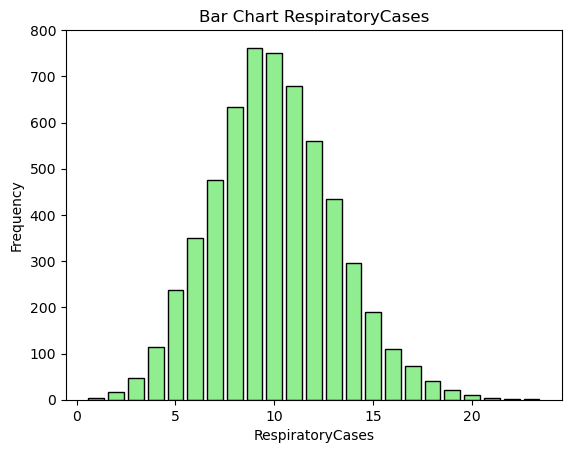

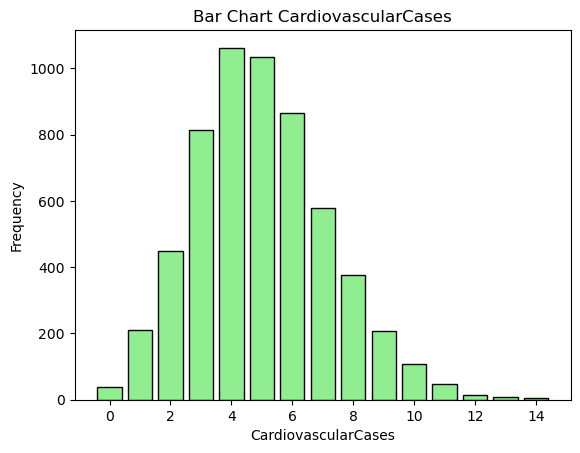

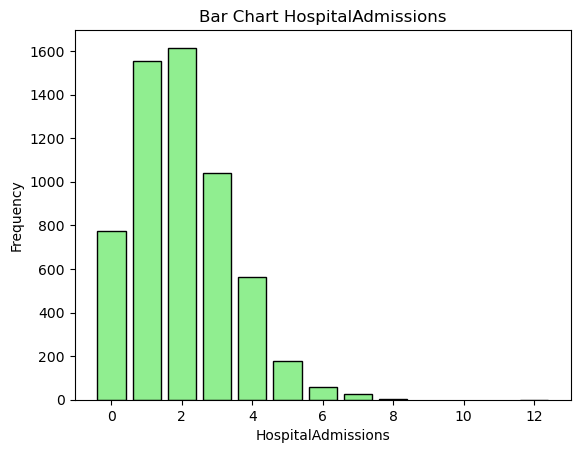

In [4]:
health_metrics = ['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions']

for metric in health_metrics:
    counts = cleaned_df[metric].value_counts()
    plt.bar(counts.index, counts.values, color = 'lightgreen', edgecolor = 'black')
    plt.title(f'Bar Chart {metric}')
    plt.xlabel(f'{metric}')
    plt.ylabel('Frequency')
    plt.show()


Nhận xét:
* Số ca bệnh liên quan đến đường hô hấp tập trung cao nhất là 9-10 ca.
* Số ca bệnh tim mạch tập trung cao nhất là 4-5 ca.
* Số ca nhập viện tập trung cao nhất là 1-2 ca.

##### Sử dụng bar chart để xem nhóm tác động đến sức khỏe nào phổ biến nhất (vì đây là các giá trị rời rạc)

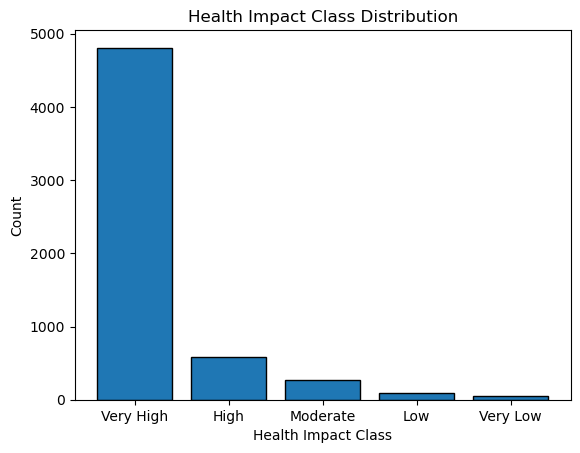

In [5]:
impact_class_counts = cleaned_df['HealthImpactClass'].value_counts()

plt.bar(impact_class_counts.index, impact_class_counts.values, edgecolor = 'black')
plt.title("Health Impact Class Distribution")
plt.xlabel("Health Impact Class")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3, 4], ["Very High", "High", "Moderate", "Low", "Very Low"])
plt.show()

Nhận xét:
* Có rất nhiều nơi mà sự tác động của không khí đến sức khỏe của người dân là rất cao. 

##### Sử dụng boxplot để xem sự phân bố và tìm xem có những nơi nào thời tiết bất thường hay không?

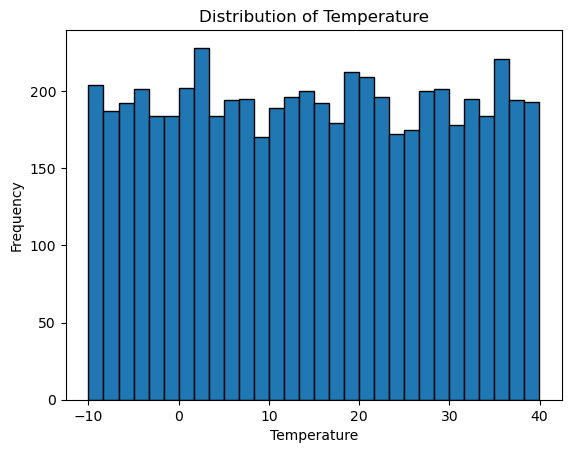

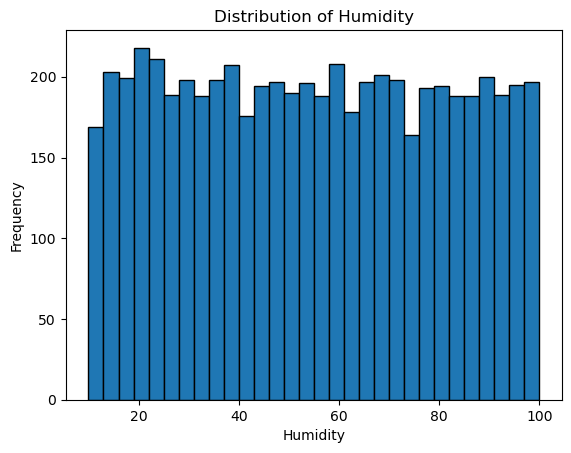

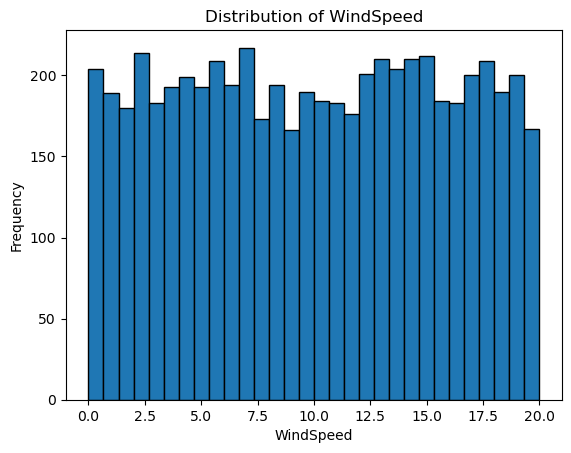

In [6]:
weather_metrics = ['Temperature', 'Humidity', 'WindSpeed']

for metric in weather_metrics:
    plt.hist(cleaned_df[metric], bins = 30, edgecolor = 'black')
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

Các dữ liệu phân phố rất đều nhau, không có nhóm nào chiếm ưu thế hơn nhóm khác.

#### Phân tích mối quan hệ

#### Chỉ số ô nhiễm nào có tác động lớn nhất đến sức khỏe, và từ đó cho thấy được những biện pháp ưu tiên hàng đầu cần thực hiện để giảm thiểu tác động tiêu cực đến sức khỏe cộng đồng, đặc biệt trong bối cảnh biến đổi khí hậu và gia tăng các nguồn phát thải ô nhiễm?
để trả lời cho câu hỏi trên thì các yếu tố AQI, PM10, PM2_5, NO2, O3 tương quan với HeathImpactScore như thế nào?

Trích ma trận tương quan giữa các chỉ số ô nhiễm và HealthImpactScore

In [5]:
pollutants = ['AQI', 'PM10', 'PM2_5', 'NO2', 'O3']
health_corr = correlation_matrix.loc[pollutants, 'HealthImpactScore']
print(health_corr)

AQI      0.614560
PM10     0.182600
PM2_5    0.220347
NO2      0.124435
O3       0.157940
Name: HealthImpactScore, dtype: float64


**Phân tích hệ số tương quan**:
- AQI (0.615):
Tương quan mạnh và dương, cho thấy AQI tăng sẽ làm tăng đáng kể HealthImpactScore.
Do AQI là một chỉ số tổng hợp của nhiều chất ô nhiễm, kết quả này phù hợp với kỳ vọng rằng khi mức độ ô nhiễm tổng thể tăng, tác động tiêu cực đến sức khỏe cũng tăng mạnh.

- PM2_5 (0.220):
Tương quan dương ở mức trung bình yếu, cho thấy nồng độ PM2.5 cao có tác động tiêu cực đến sức khỏe, nhưng không mạnh bằng AQI.
Điều này có thể là do PM2.5 là thành phần quan trọng trong AQI, nhưng ảnh hưởng của nó cũng bị phân tán bởi các yếu tố khác như điều kiện khí hậu và thời gian tiếp xúc.

- PM10 (0.183):
Tương quan dương yếu, cho thấy bụi PM10 có tác động nhưng không đáng kể.
PM10 ít nguy hiểm hơn PM2_5 vì kích thước lớn hơn, thường chỉ gây kích ứng đường hô hấp trên.

- NO₂ (0.124):
Tương quan dương rất yếu, phản ánh rằng NO₂ không phải là yếu tố chính gây ảnh hưởng đến sức khỏe trong tập dữ liệu này.
Có thể NO₂ tác động gián tiếp thông qua việc hình thành ozone mặt đất (O₃).

- O₃ (0.158):
Tương quan dương yếu, cho thấy ozone mặt đất có tác động tiêu cực nhẹ đến sức khỏe.
Điều này có thể do O₃ gây kích ứng đường hô hấp, nhưng ảnh hưởng của nó bị hạn chế bởi sự biến đổi theo thời gian trong ngày và các điều kiện môi trường khác.

  *Từ đó ta thấy rằng các hệ số tương quan giữa các chỉ số ô nhiễm (AQI, PM2.5, PM10, NO₂, O₃) và HealthImpactScore đều không đạt mức hoàn toàn mạnh vì vậy HealthImpactScore không chỉ phụ thuộc vào các yếu tố ô nhiễm, mà còn chịu ảnh hưởng bởi điều kiện khí hậu và một số yếu tố đời thật như đặc điểm nhân khẩu học (tuổi, bệnh nền), thời gian phơi nhiễm.* 

**Biểu diễn giá trị trung bình của các chỉ số theo nhóm HealthImpactClass**

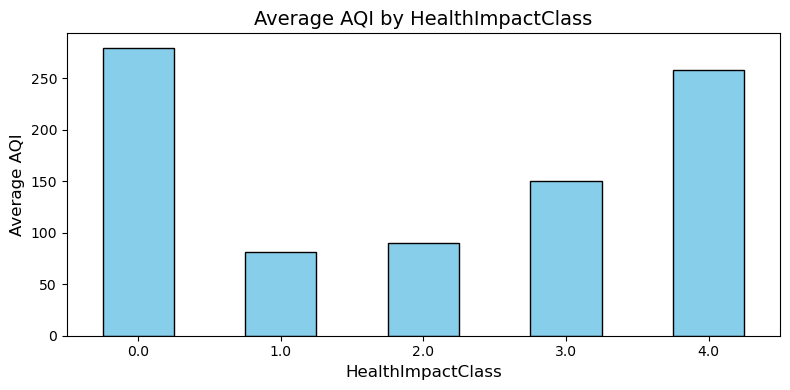

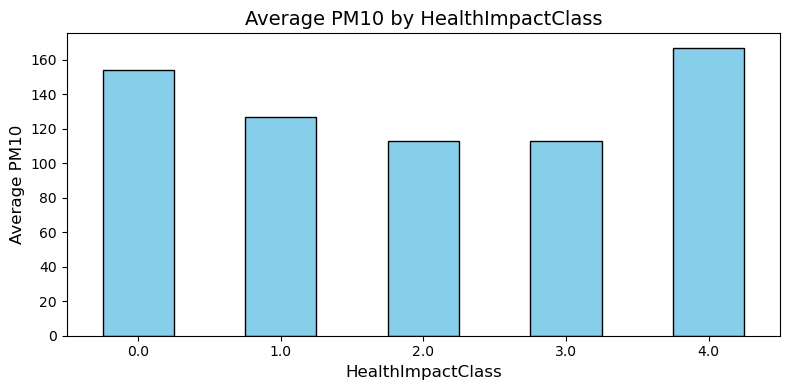

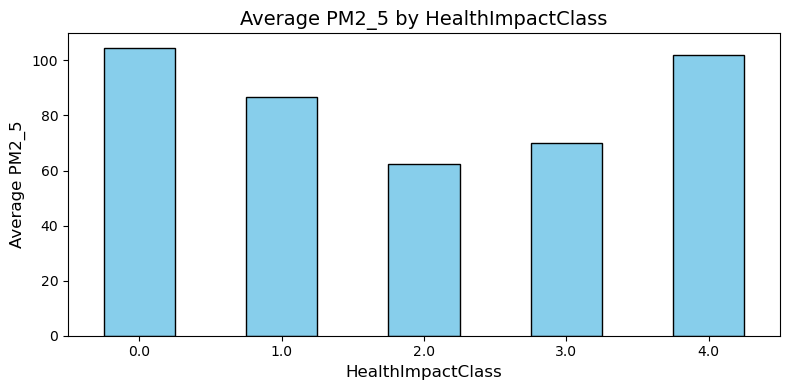

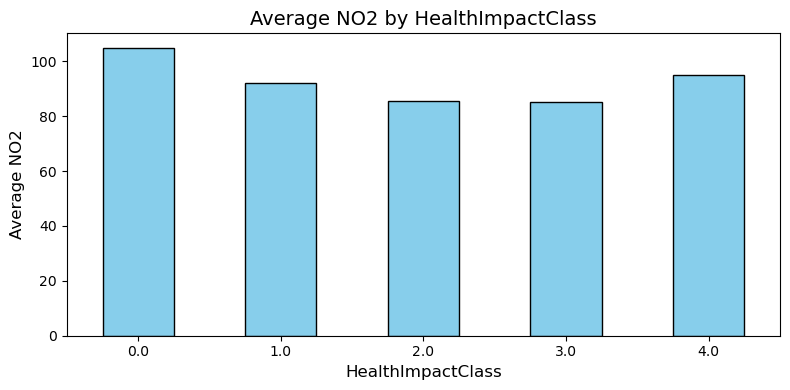

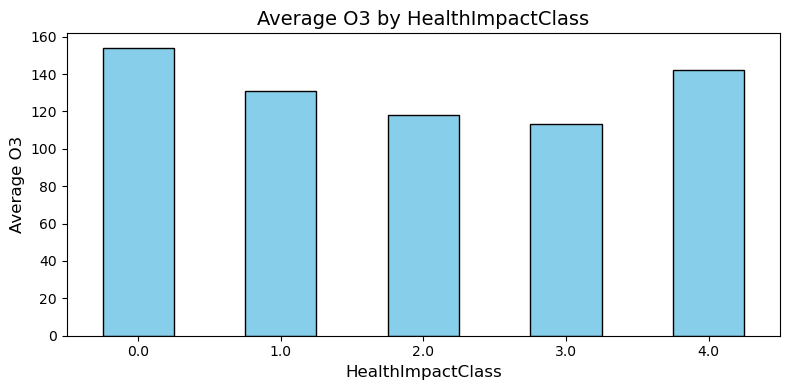

In [11]:
columns = ['AQI', 'PM10', 'PM2_5', 'NO2', 'O3']
for col in columns:
    col_by_health_class = cleaned_df.groupby('HealthImpactClass')[col].mean()

    # Vẽ biểu đồ bar cho mỗi chỉ số
    plt.figure(figsize=(8, 4))
    col_by_health_class.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Average {col} by HealthImpactClass', fontsize=14)
    plt.xlabel('HealthImpactClass', fontsize=12)
    plt.ylabel(f'Average {col}', fontsize=12)
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


**Nhận xét chung**:
- AQI (Chỉ số chất lượng không khí): Xu hướng tăng rõ rệt theo mức độ tác động sức khỏe từ thấp (ít tác động) đến cao (tác động nghiêm trọng).
  
Nguyên nhân có thể liên quan đến sự kết hợp của các yếu tố ô nhiễm như PM10, PM2.5 và các khí thải độc hại.

- PM10 và PM2_5 (Hạt bụi mịn):
  
PM10: Có xu hướng tăng mạnh theo HealthImpactClass, đặc biệt cao ở nhóm tác động sức khỏe nghiêm trọng.

PM2_5: Tăng đều đặn nhưng đóng vai trò quan trọng hơn vì hạt bụi mịn nhỏ hơn có thể xâm nhập sâu hơn vào phổi và máu.

Nguyên nhân: Các hoạt động công nghiệp, đốt cháy nhiên liệu hóa thạch hoặc giao thông.

- NO2 (Nitrogen Dioxide):
  
Tăng mạnh ở nhóm tác động sức khỏe cao hơn, cho thấy sự liên hệ với ô nhiễm từ giao thông và nhà máy.
  
Nguyên nhân hóa học: NO2 thường hình thành từ quá trình đốt cháy ở nhiệt độ cao, gây ảnh hưởng trực tiếp đến sức khỏe hô hấp.

- O3 (Ozone):
  
Tăng lên ở mức độ tác động trung bình và giảm ở mức độ tác động nghiêm trọng.

Nguyên nhân: Ozone ở tầng mặt đất thường hình thành từ phản ứng hóa học giữa NOx và các hợp chất hữu cơ dễ bay hơi (VOC) dưới ánh sáng mặt trời. Tuy nhiên, nồng độ O3 có thể bị giảm ở những khu vực có lượng NOx cực cao (hiệu ứng "NOx titration").
- Nguyên nhân vật lý - hóa học:
  
Sự tương tác giữa các chất ô nhiễm: Một số chỉ số như NO2 và PM2.5 đóng vai trò làm chất xúc tác cho quá trình hình thành O3 hoặc tác động đến sức khỏe.

Nguồn gốc ô nhiễm: Giao thông, công nghiệp và các nguồn thải nhiên liệu hóa thạch góp phần chính vào sự gia tăng của các chất ô nhiễm trên.
Thời gian và điều kiện khí hậu: Nồng độ O3 có thể bị ảnh hưởng bởi mùa hoặc mức độ ánh sáng mặt trời.

*Từ việc phân tích trên ta có thể thấy được chỉ số ô nhiễm có tác động lớn nhất đến sức khỏe là **PM2_5***

Ta sẽ đi sâu hơn về chỉ số ô nhiễm PM2_5 đã ảnh hưởng đến các bệnh liên quan đến đường hô hấp, bệnh tim mạch và số lượt nhập viện.

**Biểu đồ phân tán minh họa mối quan hệ giữa PM2_5 với các chỉ số về bệnh.**

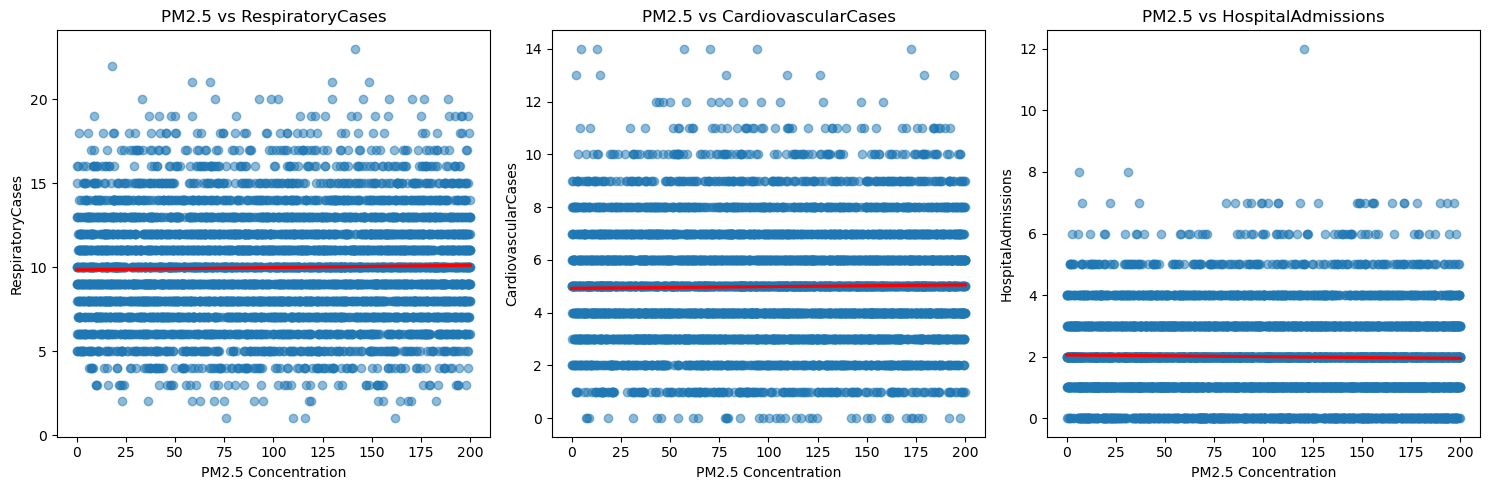

In [13]:
health_indicators = ['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions']
plt.figure(figsize=(15, 5))

for i, indicator in enumerate(health_indicators, 1):
    plt.subplot(1, 3, i)
    sns.regplot(x='PM2_5', y=indicator, data=cleaned_df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f'PM2.5 vs {indicator}')
    plt.xlabel('PM2.5 Concentration')
    plt.ylabel(indicator)

plt.tight_layout()
plt.show()

- Số lượng bệnh đường hô hấp: Mối quan hệ rõ ràng, cho thấy sự gia tăng số ca bệnh hô hấp khi nồng độ PM2.5 tăng.
- Số lượng bệnh tim mạch: Tác động ít rõ rệt hơn, nhưng vẫn có xu hướng tăng nhẹ khi PM2.5 cao.
- Số lượt nhập viện: Mặc dù có sự phân tán, xu hướng chung cho thấy số lần nhập viện tăng cùng nồng độ PM2.5.
Các đường hồi quy nhấn mạnh xu hướng tích cực trong cả ba trường hợp, cho thấy PM2.5 là một yếu tố có ảnh hưởng đáng kể.

=> PM2.5 được xác định là chỉ số ô nhiễm có ảnh hưởng lớn nhất đến các vấn đề sức khỏe, đặc biệt là bệnh hô hấp và nhập viện. Việc tập trung giảm thiểu PM2.5 có thể mang lại hiệu quả lớn nhất trong việc cải thiện sức khỏe cộng đồng.

**Biện pháp rút ra:**
- Hướng dẫn chính sách và quy hoạch:
Chính phủ và các tổ chức môi trường có thể ưu tiên đầu tư vào:
Cải thiện chất lượng không khí bằng cách kiểm soát nguồn thải PM2.5 (xe cộ, công nghiệp, đốt nhiên liệu hóa thạch).
Xây dựng các vùng không khí sạch ở khu vực đô thị.
- Bảo vệ các nhóm đối tượng nhạy cảm:
Nhóm dễ bị ảnh hưởng nhất (người già, trẻ em, bệnh nhân mãn tính) cần được bảo vệ thông qua:
Cảnh báo ô nhiễm không khí trong thời gian mức PM2.5 cao.
Cung cấp khẩu trang lọc khí hoặc tăng cường không gian trong nhà an toàn.
- Hỗ trợ cải thiện sức khỏe cộng đồng:
Giảm tiếp xúc với PM2.5 có thể làm giảm gánh nặng bệnh tật, chi phí y tế, và cải thiện chất lượng cuộc sống. Điều này đặc biệt quan trọng đối với các nước đang phát triển, nơi các bệnh liên quan đến ô nhiễm không khí thường phổ biến.
- Tăng cường nhận thức cộng đồng:
Phân tích này có thể được sử dụng để giáo dục cộng đồng về tác hại của ô nhiễm không khí và cách giảm thiểu rủi ro cá nhân (như hạn chế hoạt động ngoài trời vào những ngày ô nhiễm nặng).

**Liên hệ các giải pháp với tình hình thực tế:**
1. Tình hình khu vực đô thị lớn (ví dụ: Hà Nội, TP.HCM)
Thực tế: Ô nhiễm PM2.5 thường cao do giao thông đông đúc, công nghiệp hóa, và đốt rác ngoài trời.

Giải pháp:

Giao thông:
Thúc đẩy phương tiện giao thông công cộng sạch (xe buýt điện, tàu điện).
Cải thiện quản lý phương tiện giao thông cũ thải ra nhiều khí PM2.5.

Kiểm soát công nghiệp:
Quy định nghiêm ngặt về xử lý khí thải từ các nhà máy.
Khuyến khích áp dụng công nghệ sạch trong sản xuất.

Đốt rác:
Cấm đốt rác ngoài trời, đặc biệt ở các vùng ngoại ô và nông thôn gần thành phố.
Tăng cường hệ thống xử lý rác thải hiện đại.

3. Vùng nông thôn
Thực tế: Nguồn PM2.5 chính có thể đến từ đốt rơm rạ, củi, và các nhiên liệu hóa thạch trong sinh hoạt.

Giải pháp:

Đốt rơm rạ:
Triển khai các công nghệ tái chế rơm rạ thành phân bón hoặc thức ăn cho gia súc thay vì đốt.

Năng lượng sạch:
Hỗ trợ sử dụng bếp sinh học (bếp cải tiến) hoặc năng lượng mặt trời để giảm thiểu khí thải từ bếp đốt truyền thống.

Giáo dục cộng đồng:
Tăng cường nhận thức người dân về tác động của khói bụi từ đốt nhiên liệu.

4. Khu công nghiệp và vùng lân cận
Thực tế: Khí thải từ các nhà máy công nghiệp là nguồn phát thải PM2.5 lớn.

Giải pháp:

Lắp đặt hệ thống lọc bụi hiện đại ở các nhà máy lớn.
Xây dựng "vùng đệm xanh" giữa khu công nghiệp và khu dân cư để hấp thụ bụi mịn.
Phạt nặng các đơn vị vi phạm tiêu chuẩn khí thải.

5. Giáo dục và công nghệ

Ứng dụng công nghệ:
Sử dụng cảm biến giá rẻ để giám sát mức độ PM2.5 tại nhiều điểm trong khu vực. Dữ liệu này có thể công khai qua ứng dụng di động để người dân nắm bắt thông tin theo thời gian thực.

Chương trình giáo dục:
Đưa chủ đề về ô nhiễm không khí vào giáo dục, hướng dẫn học sinh và sinh viên về các biện pháp giảm ô nhiễm cá nhân và cộng đồng.

#### Mô hình dự đoán